In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


# Exploratory analysis of Swiss Products

In [4]:
swissDF  = pd.read_csv("Datasets/Swiss_reviews.csv")

In [5]:
def transformToList(x):
    newList=[]
    for i in range(1, len(x)):
        if i%2 != 0 :
            newList.append(x[i])
    return newList


def transformCategories(df):
    if 'Unnamed: 0' in df:
        df.drop('Unnamed: 0', axis=1, inplace=True)
    df = df[df.categories.notnull()]
    df['categories'] = df['categories'].apply(lambda x: x.split("'"))
    df['categories'] = df['categories'].apply(lambda x : transformToList(x))
    return df

swissDF = transformCategories(swissDF)

One of the first thing we'll need to do is transform the categories, which are a string right now, into a list of string.

In [6]:
swissDF.describe()

,overall,unixReviewTime,year,sentiment
count,289878.000000,2.898780e+05,289878.000000,289878.000000
mean,4.195468,1.349118e+09,2012.286110,0.647099
std,1.234766,5.677473e+07,1.838564,0.499193
min,1.000000,9.527328e+08,2000.000000,-0.998900
25%,4.000000,1.327882e+09,2012.000000,0.608300
50%,5.000000,1.367280e+09,2013.000000,0.879300
75%,5.000000,1.388966e+09,2014.000000,0.951700
max,5.000000,1.406074e+09,2014.000000,0.999900


In [7]:
swissDF.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,categories,year,sentiment
0,B000R9AAJA,"[0, 0]",5.0,Speakers are loud and clear. They work great! ...,"11 22, 2012",A0023922YYT81KP1CWU4,Steven Caruso,Great!,1353542400,Logitech,"[Electronics, Computers & Accessories, Cables ...",2012,0.9476
1,B000R9AAJA,"[1, 1]",5.0,These I bought for my co-worker who always bor...,"02 3, 2014",A034570920WVP7XFWHZ5I,Olyvia,Co-Worker is happy,1391385600,Logitech,"[Electronics, Computers & Accessories, Cables ...",2014,0.9755
2,B000R9AAJA,"[1, 1]",5.0,I bought these speakers for a friend's birthda...,"02 2, 2013",A100FXXJZMM6PI,Phillip Ly,Logitech S-120 Speakers,1359763200,Logitech,"[Electronics, Computers & Accessories, Cables ...",2013,0.8867
3,B000R9AAJA,"[1, 1]",5.0,My brother bought this speaker set for me back...,"10 20, 2012",A10636NGTJRUHN,sande276,Great!,1350691200,Logitech,"[Electronics, Computers & Accessories, Cables ...",2012,0.9463
4,B000R9AAJA,"[1, 1]",5.0,I have had these for a while and they work lik...,"01 31, 2013",A1071EF3JDBGI0,"R. Lorente ""Picky""",EXCELLENT!,1359590400,Logitech,"[Electronics, Computers & Accessories, Cables ...",2013,0.8528


We'll first look at the overall ratings, all categories mixed together

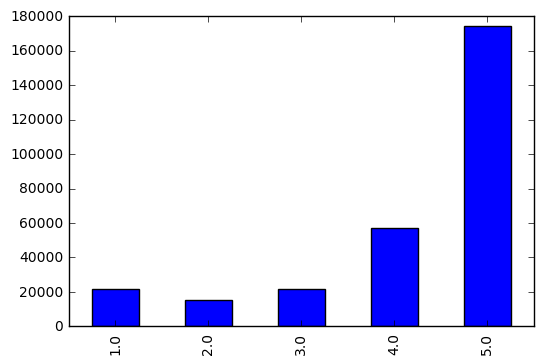

In [8]:
plot = swissDF.overall.value_counts().sort_index().plot.bar()
swissDF.overall.describe()
plt.savefig('ch_reviews')
plot

The ratings are pretty high, but as we have determined before this is also the case for international products. So basing our observations on raw evaluations isn't enough, we'll try to separate them by categories and perform sentiment analysis

In [9]:
swissDF['year'] = swissDF['reviewTime'].astype(str)
swissDF['year'] = swissDF['year'].apply(lambda x: x[-4:])

In [10]:
yearGroup =swissDF.groupby(['year'])
yearGroup['overall'].agg(['count', 'mean'])

,count,mean
year,,
2000,12,4.416667
2001,49,3.918367
2002,70,3.942857
2003,205,4.136585
2004,307,3.491857
2005,826,3.984262
2006,1893,4.078711
2007,5514,4.273486
2008,7366,4.250068


The mean seems pretty consistent. with a few exceptions like 2004 which is probably due to a very inpopular product released back then. It also seems like the number of reviews is increasing exponentially.

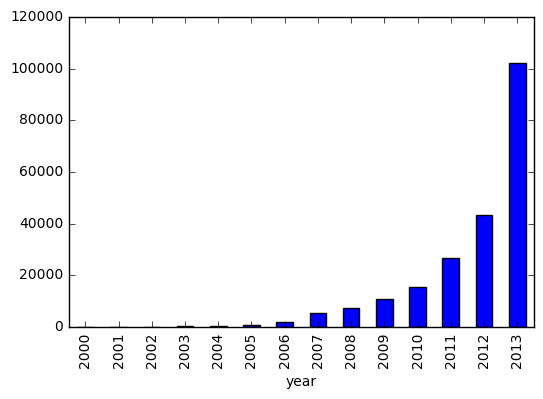

In [11]:
plot = yearGroup['overall'].count()[:-1].plot.bar()
plot
plt.savefig('ch_reviews_year')

2014 might seem smaller than 2013, but this data was collected in July 2014 which explains it.

We will now look at the dsitribution of reviews among swiss brands. Because some of them are much more popular than others (logitech being the most popular one) we will plot it using a logarithmic scale

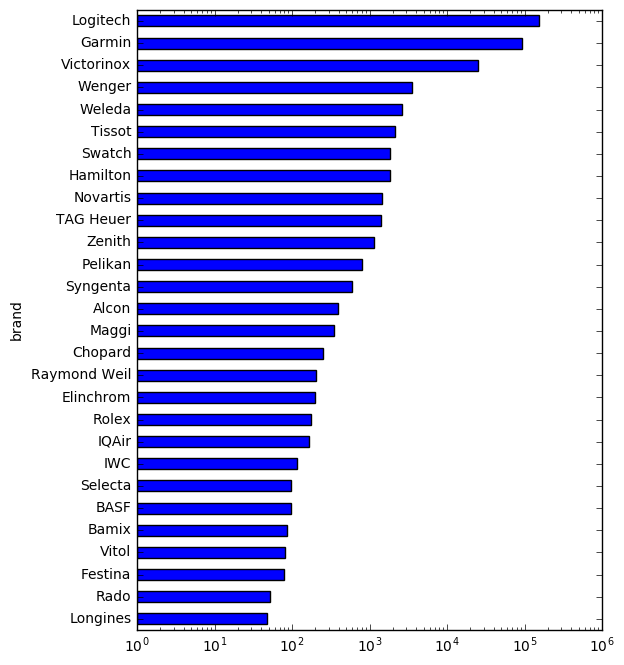

In [12]:
brands_rcounts = swissDF.groupby(['brand'])['brand'].count()
plot = brands_rcounts.sort_values(ascending=True)[20:].plot.barh(log=True, figsize=(6, 8))
plot
plt.savefig('top10_reviews_by_brand')

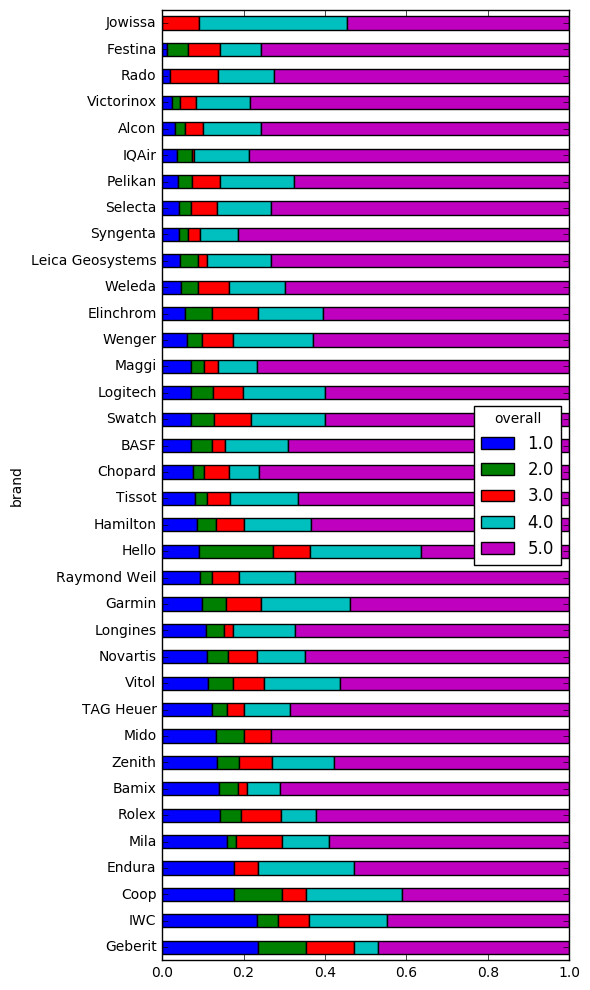

In [13]:
brandScore = swissDF.groupby(['brand', 'overall'])['brand']
brandScore = brandScore.count().unstack('overall')
brandScore2 = brandScore.join(brands_rcounts).rename(columns={'brand': 'count'})
brandScore2 = brandScore2[brandScore2['count'] > 10].drop('count', axis=1)
plot = brandScore2.div(brandScore2.sum(1), 0).sort_values(by=brandScore2.keys()[0], ascending=False).plot(kind='barh', stacked=True, figsize=(6,10))
#problem here, the ratings are also put on a log scale so it seems like there are too many 1s. We could try to fix it or replace
#by piecharts
plt.tight_layout()
plt.savefig('brands_by_12345')

We will now group the reviews by category

In [14]:
categoriesCount = pd.DataFrame(swissDF['categories'].tolist()).stack().value_counts()
categoriesCount.head()

Electronics                  218203
Computers & Accessories      116378
Cables & Accessories          94113
GPS & Navigation              75883
Clothing, Shoes & Jewelry     45919
dtype: int64

Let's focus on the most reviewed categories

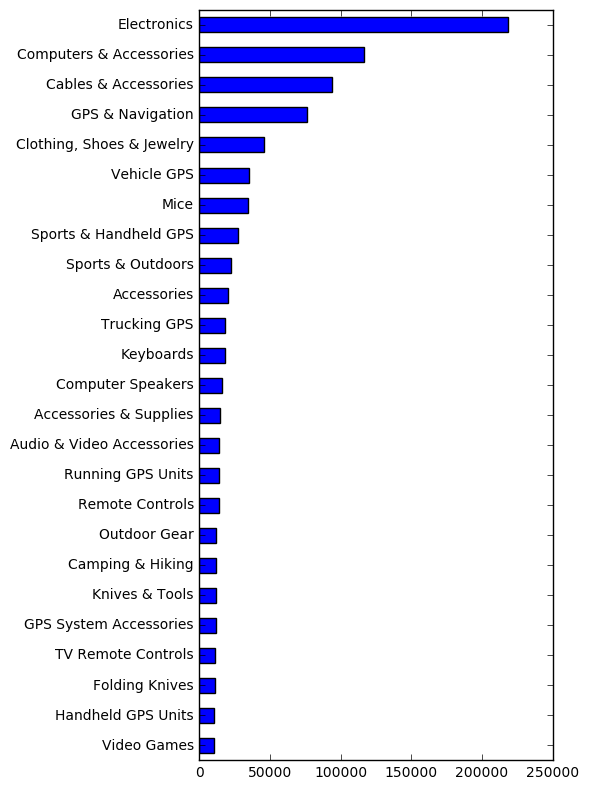

In [15]:
categoriesCount = categoriesCount.head(25)
categoriesCount.sort_values(inplace=False, ascending=True).plot.barh(figsize=(6,8))
plt.tight_layout()
plt.savefig('top25_reviewed_cats')

In [16]:
categoriesCount.head()

Electronics                  218203
Computers & Accessories      116378
Cables & Accessories          94113
GPS & Navigation              75883
Clothing, Shoes & Jewelry     45919
dtype: int64

In [17]:
categoriesCount.count()

25

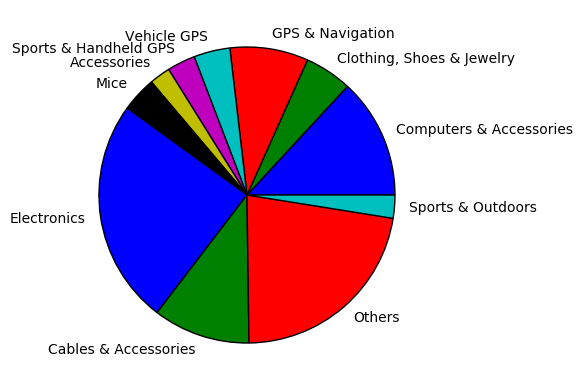

In [18]:
total = categoriesCount.sum()
top10 = categoriesCount.sort_values(ascending=False).head(10)
top10.loc['Others'] = total - top10.sum()
plot = top10.sample(frac=1).plot.pie()
plot.set_ylabel('')
plot.set_aspect('equal')
plt.tight_layout()
plt.savefig('top10_cat_pie')

We will now take a look at how well rated each of these categories are

In [19]:
categoriesCount.keys()

Index(['Electronics', 'Computers & Accessories', 'Cables & Accessories',
       'GPS & Navigation', 'Clothing, Shoes & Jewelry', 'Vehicle GPS', 'Mice',
       'Sports & Handheld GPS', 'Sports & Outdoors', 'Accessories',
       'Trucking GPS', 'Keyboards', 'Computer Speakers',
       'Accessories & Supplies', 'Audio & Video Accessories',
       'Running GPS Units', 'Remote Controls', 'Outdoor Gear',
       'Camping & Hiking', 'Knives & Tools', 'GPS System Accessories',
       'TV Remote Controls', 'Folding Knives', 'Handheld GPS Units',
       'Video Games'],
      dtype='object')

To find the entries that contain one category, the code to use looks like this

In [20]:
swissDF.categories.apply(lambda x: ' '.join(x)).str.contains('Electronics').head()

0    True
1    True
2    True
3    True
4    True
Name: categories, dtype: bool

In [21]:
flat2 = swissDF.categories.apply(lambda x: ' '.join(x)).str
res2 = categoriesCount.keys().to_series().map(lambda c: swissDF[flat2.contains(c)].overall.std())

In [22]:
res2 = res2.reset_index(drop=False)

In [23]:
res2.columns = ['Category', 'Std']

In [24]:
res2.set_index('Category', inplace=True)

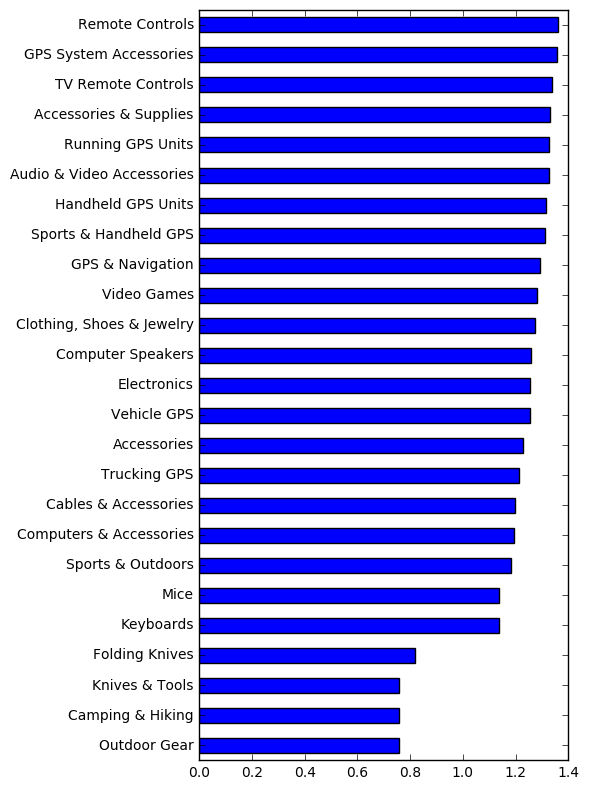

In [25]:
plot = res2.sort_values(by='Std',ascending=True).plot.barh(figsize=(6,8),legend=None)
plot.set_ylabel('')
plt.tight_layout()
plt.savefig('categories_std')

In [26]:
flat = swissDF.categories.apply(lambda x: ' '.join(x)).str
res = categoriesCount.keys().to_series().map(lambda c: swissDF[flat.contains(c)].overall.mean())

In [27]:
res = res.reset_index(drop=False)

In [28]:
res.columns = ['category', 'mean of swiss products']

In [29]:
res = res.set_index(['category'])
res.head()

,mean of swiss products
category,
Electronics,4.151909
Computers & Accessories,4.237529
Cables & Accessories,4.240466
GPS & Navigation,4.077727
"Clothing, Shoes & Jewelry",4.236315


Let's now plot these means in decreasing order, later in the notebook we will compare those means with that of foreign products

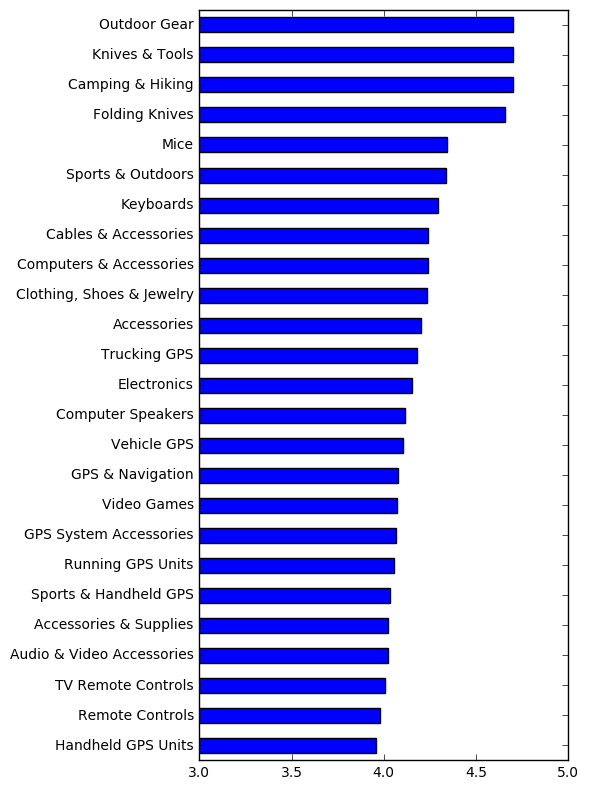

In [30]:
plot = res.sort_values(by='mean of swiss products',ascending=True).plot.barh(figsize=(6,8),legend=None)
plot.set_ylabel('')
plot.set_xlim(3,5)
plt.tight_layout()
plt.savefig('categories_means')

In [31]:
prods = swissDF[['asin', 'categories']].drop_duplicates('asin').set_index('asin')
prods.head()

,categories
asin,
B000R9AAJA,"[Electronics, Computers & Accessories, Cables ..."
B002FU5QM0,"[Electronics, Computers & Accessories, Cables ..."
B003LCV4RM,"[Patio, Lawn & Garden, Pest Control, Lures]"
B0015C30J0,"[Electronics, Computers & Accessories, Cables ..."
B002FU5QLQ,"[Electronics, Computers & Accessories, Cables ..."


In [32]:
flat = prods.categories.apply(lambda x: ' '.join(x)).str
prodsbyCat = categoriesCount.keys().to_series().apply(lambda c: prods[flat.contains(c)].count())
#res = categoriesCount.keys().to_series().map(lambda c: swissDF[flat.contains(c)].overall.mean())
prodsbyCat

,categories
Electronics,1302
Computers & Accessories,533
Cables & Accessories,363
GPS & Navigation,457
"Clothing, Shoes & Jewelry",1649
Vehicle GPS,54
Mice,161
Sports & Handheld GPS,146
Sports & Outdoors,506
Accessories,1626


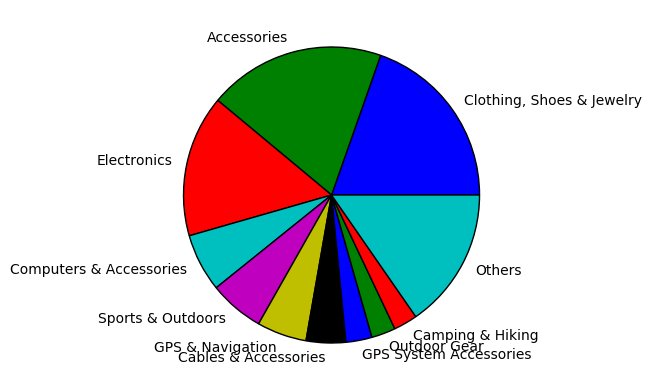

In [33]:
top10pbc = prodsbyCat.sort_values('categories', ascending=False).head(10)
top10pbc.loc['Others'] = prodsbyCat.sum() - top10pbc.sum()
plot = top10pbc['categories'].plot.pie()
plot.set_ylabel('')
plot.set_aspect('equal')
plt.tight_layout()
plt.savefig('top10_pbc')

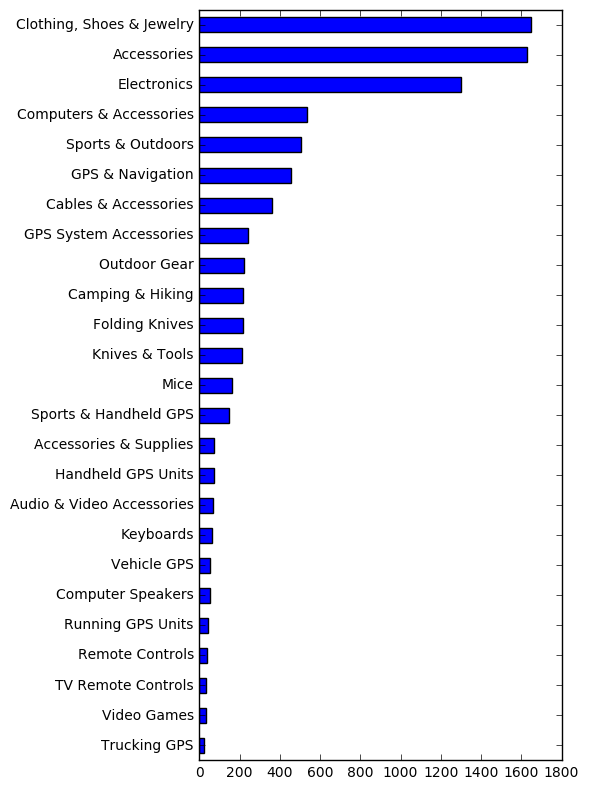

In [34]:
prodsbyCat.sort_values('categories').plot.barh(figsize=(6,8), legend=None)
plt.tight_layout()
plt.savefig('prods_by_cat')

The last thing we need to check is to see what happens if we group the reviews first by product. This will show us if for example some very popular results are skewing the means

In [35]:
productGroup = swissDF.groupby(['asin'])
productFrame = pd.DataFrame(productGroup['overall'].agg(['count', 'mean']))
overallGrouped = productFrame['mean']

In [36]:
productFrame.count()

count    4718
mean     4718
dtype: int64

We can see that we have 4718 unique products in total. 
Now let's get the mean product wise

In [37]:
print(np.mean(productFrame['mean']))
print(np.median(productFrame['mean']))

4.246266143689977
4.44117647059


Everything looks normal, which means that we have a relatively normal distrubtion of the reviews accros the products

In [38]:
productFrame['asin'] = productFrame.index
productFrame['brand'] = productGroup.apply(lambda x: list(x.brand)[0])
productFrame.index = range(0, 4718)
brands = productFrame.groupby(['brand'])['mean'].agg(['count', 'mean', 'median']).sort_values(['count'])

In [39]:
brands = brands.sort_values(['mean'], ascending=False).join(brands_rcounts)

In [40]:
brands.rename(columns={'brand': 'reviews'}, inplace=True)

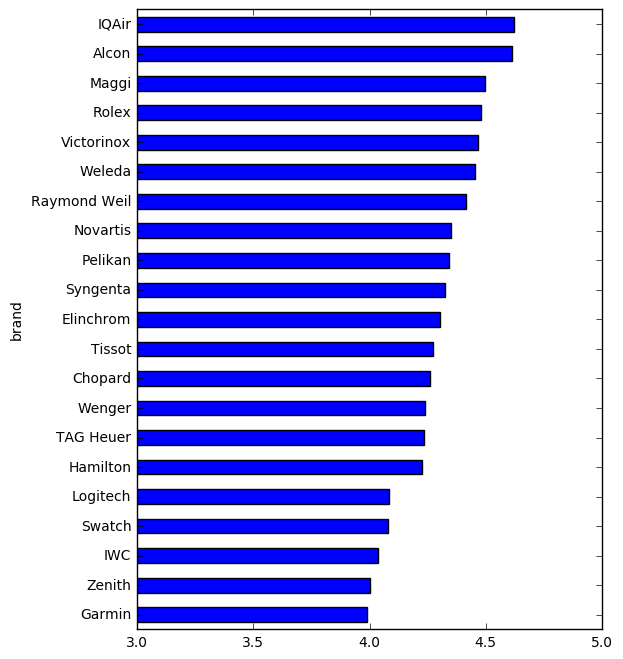

In [41]:
plot = brands[brands.reviews > 100].sort_values(['mean'], ascending=True)['mean'].plot.barh(figsize=[6,8])
plot.set_xlim(3,5)
plt.savefig('best_rated_brands')

This is very nice view as it shows us which brands have the most products as well as the mean and the median review for each brand. 
In general we can say that most brands, especially the most popoluar ones, are very close to the general mean and distribtuion

In [42]:
brands[brands['count'] <= 100].count()

count      38
mean       38
median     38
reviews    38
dtype: int64

In [43]:
brands.count()

count      48
mean       48
median     48
reviews    48
dtype: int64

In [44]:
brands.sort_values(['count'], ascending=False)[:3]

,count,mean,median,reviews
brand,,,,
Victorinox,1056,4.466100,4.666667,25439
Garmin,780,3.991383,4.031929,92735
Logitech,595,4.084449,4.200000,151795


In [45]:
brands.sort_values(['count'], ascending=False)[:3]['count'].sum() / brands['count'].sum()

0.5152607036880034

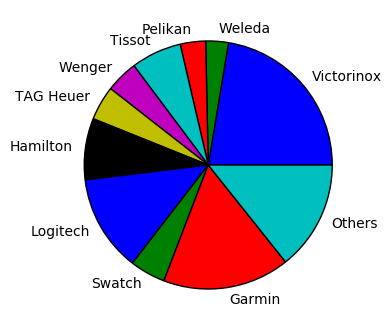

In [46]:
over100 = brands[brands['count'] > 100]['count']
over100.loc['Others'] = brands['count'].sum() - over100.sum()
plot = over100.plot.pie(figsize=[4, 4])
plot.set_ylabel('')
plt.savefig('brands_shares')

Brands repartition of swiss products on amazon.

In [47]:
import ast
helpful = []
for i in range(0, len(swissDF)):
    helpful.append(ast.literal_eval(swissDF['helpful'][i])[1] + 1)


In [48]:
swissDF['helpful'] = helpful
swissDF['coeff'] = swissDF['helpful'] * swissDF['overall']
productGroup = swissDF.groupby(['asin'])
productFrameWeighted = pd.DataFrame(productGroup['coeff'].agg(['count', 'sum']))
temp = pd.DataFrame(productGroup['helpful'].agg(['sum']))

In [49]:
productFrameWeighted['mean'] = productFrameWeighted['sum']/temp['sum']

In [50]:
print(np.mean(productFrameWeighted['mean']))
print(np.median(productFrameWeighted['mean']))

4.11279668207142
4.3307007176


# TEXT ANALYSIS

Now that we have finished working with the numerical ratings, we'll try to look for differences between Swiss and international products by basing our analysis on text.
First we'll start with the "summary" column

In [51]:
from nltk.sentiment.vader import *

In [52]:
stopwords = pd.read_csv('Datasets/stopwords_en.csv')

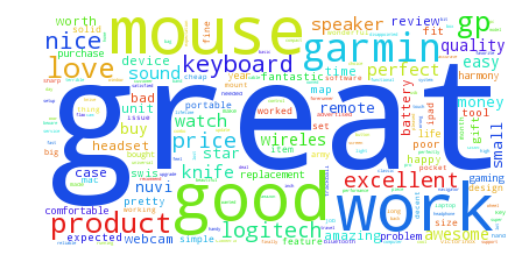

In [53]:
summaryBody = swissDF['summary'].apply(lambda x: x.lower())
textArray = summaryBody.values.flatten()
textString = ' '.join(textArray)
cloud = WordCloud(background_color="white", stopwords=stopwords).generate(textString)
plt.imshow(cloud)
plt.axis('off')
plt.show()

The code below was run to execute the sentiment analysis of the reviews, we have now commented it because the result was added to the dataframe

In [54]:
#analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer()

We will now perform sentiment analysis on the review text joined with the summary

In [55]:
#review_polarity = []
#for i in range (0, len(USDF['reviewText'])):
#    review_polarity.append(analyzer.polarity_scores(' '.join([str(USDF['reviewText'][i]), USDF['summary'][i]]))['compound'])
#    if i % 1000 == 0:
#        print(i)

In [56]:
#len(review_polarity)

In [57]:
productGroup = swissDF.groupby(['asin'])
productFrame = pd.DataFrame(productGroup['sentiment'].agg(['count', 'mean']))

In [58]:
print("Mean of sentiment")
print(np.mean(productFrame['mean']))
print(np.median(productFrame['mean']))

Mean of sentiment
0.6534338998560479
0.72615


In [59]:
productFrame['asin'] = productFrame.index
productFrame['brand'] = productGroup.apply(lambda x: list(x.brand)[0])
productFrame.index = range(0, 4718)
productFrame.groupby(['brand'])['mean'].agg(['count', 'mean', 'median']).sort_values(['count'], ascending=False)

,count,mean,median
brand,,,
Victorinox,1056,0.712119,0.779360
Garmin,780,0.501308,0.547487
Logitech,595,0.629216,0.688054
Hamilton,378,0.661859,0.794742
Tissot,311,0.712240,0.790889
Swatch,219,0.653385,0.731450
TAG Heuer,211,0.702715,0.774700
Wenger,199,0.665085,0.742008
Pelikan,156,0.706711,0.819700


In [60]:
np.corrcoef(swissDF['overall'], swissDF['sentiment'])

array([[ 1.        ,  0.55085136],
       [ 0.55085136,  1.        ]])

The correlation is 0.55, which indicates a moderatetly high correlation between the overall rating and the review. While the correlation is not very high at least it provides us with some basis to use the sentiment analysis for comparison.

productFrame['overallGrouped'] = overallGrouped.tolist()
A = np.vstack([productFrame['mean'].tolist(),np.ones(len(productFrame['mean'].tolist()))]).T
xarr = np.array(productFrame['mean'].tolist())
m,c = np.linalg.lstsq(A,productFrame['overallGrouped'].tolist())[0]


productFrame['regression'] = (xarr*m + c)
ax = productFrame.plot.scatter(x='mean', y='regression', color="Red")
productFrame.plot.scatter(x='mean', y='overallGrouped' ,figsize=(15,15), ax=ax)

In the Comparison sections we use statistical tests and look for statisticaly significant results. Our general interpretation of the results is in our short report.

# Comparison of reviews

In [70]:
RandomDF = pd.read_csv("Datasets/RandomSample.csv")

count    298867.000000
mean          4.193016
std           1.230105
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

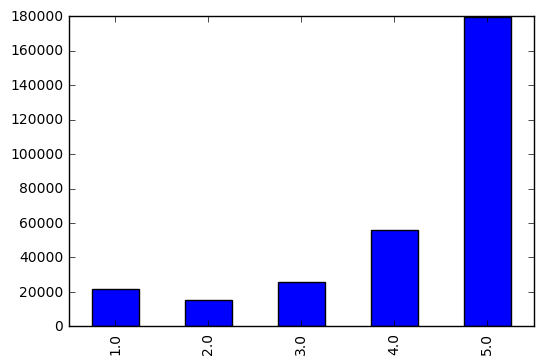

In [71]:
RandomDF.overall.value_counts().sort_index().plot.bar()
RandomDF.overall.describe()

In [72]:
scipy.stats.ttest_ind(swissDF['overall'],RandomDF['overall'], equal_var=False)

Ttest_indResult(statistic=0.76343203206340005, pvalue=0.44520608896728631)

In [73]:
scipy.stats.mannwhitneyu(swissDF['overall'],RandomDF['overall'], alternative='two-sided')

MannwhitneyuResult(statistic=43363427017.5, pvalue=0.42335681844284045)

In [74]:
GermanDF = pd.read_csv("Datasets/German_review.csv")

count    153843.000000
mean          4.155509
std           1.290023
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

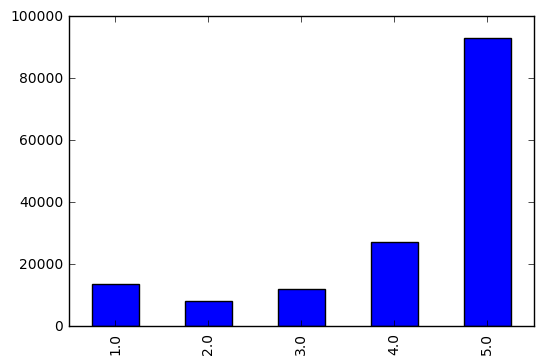

In [75]:
GermanDF.overall.value_counts().sort_index().plot.bar()
GermanDF.overall.describe()

In [76]:
scipy.stats.ttest_ind(swissDF['overall'],GermanDF['overall'], equal_var=False)

Ttest_indResult(statistic=9.965899286951716, pvalue=2.167175983670487e-23)

In [77]:
scipy.stats.mannwhitneyu(swissDF['overall'],GermanDF[ 'overall'], alternative='two-sided')

MannwhitneyuResult(statistic=22412633450.0, pvalue=0.001314498616021158)

In [78]:
scipy.stats.mannwhitneyu(swissDF['overall'],GermanDF[ 'overall'], alternative='greater')

MannwhitneyuResult(statistic=22412633450.0, pvalue=0.00065724930801057901)

In [79]:
USDF = pd.read_csv("Datasets/US_reviews.csv")

count    303939.000000
mean          4.099112
std           1.331076
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

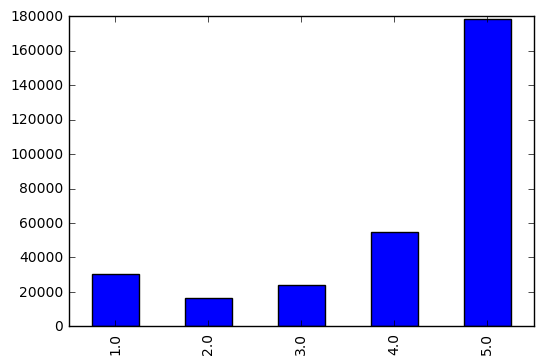

In [80]:
USDF.overall.value_counts().sort_index().plot.bar()
USDF.overall.describe()

In [81]:
scipy.stats.ttest_ind(swissDF['overall'],USDF['overall'], equal_var=False)

Ttest_indResult(statistic=28.935791963515495, pvalue=5.693712723251059e-184)

In [82]:
scipy.stats.mannwhitneyu(swissDF['overall'],USDF[ 'overall'], alternative='two-sided')

MannwhitneyuResult(statistic=45212122510.5, pvalue=1.2618068485557744e-87)

In [83]:
scipy.stats.mannwhitneyu(swissDF['overall'],USDF[ 'overall'], alternative='greater')

MannwhitneyuResult(statistic=45212122510.5, pvalue=6.3090342427788718e-88)

In [84]:
FrenchDF = pd.read_csv("Datasets/French_review.csv")

count    25642.000000
mean         4.126316
std          1.375260
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

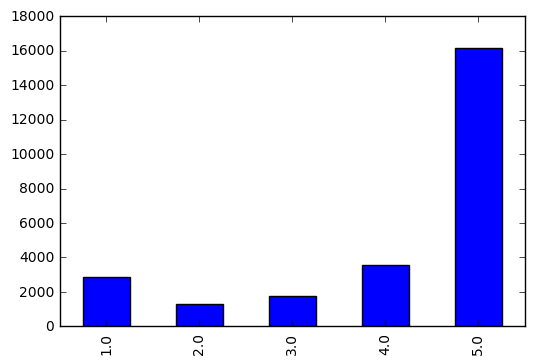

In [85]:
FrenchDF.overall.value_counts().sort_index().plot.bar()
FrenchDF.overall.describe()

In [86]:
scipy.stats.ttest_ind(swissDF['overall'],FrenchDF['overall'], equal_var=False)

Ttest_indResult(statistic=7.7792945240962261, pvalue=7.530944365807882e-15)

In [87]:
scipy.stats.mannwhitneyu(swissDF['overall'],FrenchDF[ 'overall'], alternative='two-sided')

MannwhitneyuResult(statistic=3688906157.0, pvalue=0.024588534203762509)

In [88]:
scipy.stats.mannwhitneyu(swissDF['overall'],FrenchDF[ 'overall'], alternative='less')

MannwhitneyuResult(statistic=3688906157.0, pvalue=0.012294267101881255)

# Comparison after grouping by product

In [25]:
def groupByProduct (DF):
    productGroup = DF.groupby(['asin'])
    productFrame = pd.DataFrame(productGroup['overall'].agg(['count', 'mean']))
    overallGrouped = productFrame['mean']
    return overallGrouped

In [26]:
groupByProduct(swissDF).describe()

count    4718.000000
mean        4.246266
std         0.811891
min         1.000000
25%         4.000000
50%         4.441176
75%         5.000000
max         5.000000
Name: mean, dtype: float64

In [62]:
groupByProduct(FrenchDF).describe()

count    2378.000000
mean        4.261580
std         0.941468
min         1.000000
25%         4.000000
50%         4.553288
75%         5.000000
max         5.000000
Name: mean, dtype: float64

In [63]:
groupByProduct(GermanDF).describe()

count    7930.000000
mean        4.217240
std         0.929429
min         1.000000
25%         4.000000
50%         4.500000
75%         5.000000
max         5.000000
Name: mean, dtype: float64

In [64]:
groupByProduct(USDF).describe()

count    11472.000000
mean         4.142353
std          0.966845
min          1.000000
25%          3.750000
50%          4.428571
75%          5.000000
max          5.000000
Name: mean, dtype: float64

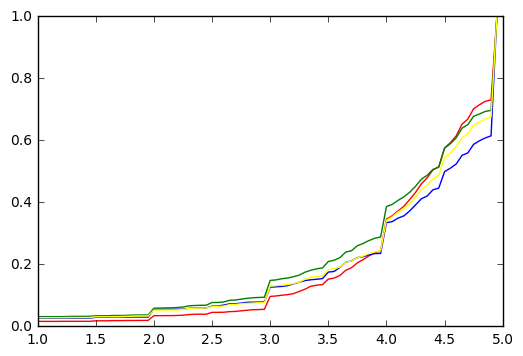

In [38]:
values, base = np.histogram(groupByProduct(swissDF), bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(groupByProduct(swissDF)), c='red')
values, base = np.histogram(groupByProduct(FrenchDF), bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(groupByProduct(FrenchDF)), c='blue')
values, base = np.histogram(groupByProduct(USDF), bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(groupByProduct(USDF)), c='green')
values, base = np.histogram(groupByProduct(GermanDF), bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(groupByProduct(GermanDF)), c='yellow')


In [47]:
scipy.stats.ks_2samp(groupByProduct(swissDF), groupByProduct(FrenchDF))

Ks_2sampResult(statistic=0.11850166015948793, pvalue=7.8845266592152299e-20)

In [48]:
scipy.stats.ks_2samp(groupByProduct(swissDF), groupByProduct(GermanDF))

Ks_2sampResult(statistic=0.057917492343721899, pvalue=4.401366952695648e-09)

In [49]:
scipy.stats.ks_2samp(groupByProduct(swissDF), groupByProduct(USDF))

Ks_2sampResult(statistic=0.06025397258961937, pvalue=5.1786547394790326e-11)

In [44]:
scipy.stats.mannwhitneyu(groupByProduct(swissDF),groupByProduct(FrenchDF),alternative='greater')

MannwhitneyuResult(statistic=5179110.5, pvalue=0.99999996014604742)

In [45]:
scipy.stats.mannwhitneyu(groupByProduct(swissDF),groupByProduct(GermanDF), alternative='greater')

MannwhitneyuResult(statistic=18225802.5, pvalue=0.99301725899103377)

In [46]:
scipy.stats.mannwhitneyu(groupByProduct(swissDF),groupByProduct(USDF), alternative='greater')

MannwhitneyuResult(statistic=27730473.5, pvalue=0.0061220507665229679)

In [54]:
scipy.stats.mannwhitneyu(groupByProduct(swissDF),groupByProduct(FrenchDF),alternative='less')

MannwhitneyuResult(statistic=5179110.5, pvalue=3.9856706546112909e-08)

In [51]:
scipy.stats.mannwhitneyu(groupByProduct(swissDF),groupByProduct(GermanDF), alternative='less')

MannwhitneyuResult(statistic=18225802.5, pvalue=0.0069828403668128784)

In [52]:
scipy.stats.mannwhitneyu(groupByProduct(swissDF),groupByProduct(USDF), alternative='less')

MannwhitneyuResult(statistic=27730473.5, pvalue=0.99387801414043553)

# Comparison after grouping by product with weight

In [55]:
import ast
def groupByProductWeight (DF):   
    helpful = []
    for i in range(0, len(DF)):
        if type(DF['helpful'][i]) == np.int64:
            helpful.append(DF['helpful'][i])
        elif type(DF['helpful'][i]) == type([]):
            helpful.append(DF['helpful'][i][1] + 1)
        else:
            helpful.append(ast.literal_eval(DF['helpful'][i])[1] + 1)
    DF['helpful_count'] = helpful
    DF['coeff'] = DF['helpful_count'] * DF['overall']
    productGroup = DF.groupby(['asin'])
    productFrameWeighted = pd.DataFrame(productGroup['coeff'].agg(['count', 'sum']))
    temp = pd.DataFrame(productGroup['helpful_count'].agg(['sum']))
    productFrameWeighted['mean'] = productFrameWeighted['sum']/temp['sum']
    return productFrameWeighted['mean']

In [56]:
groupByProductWeight(swissDF).describe()

count    4718.000000
mean        4.112797
std         0.921279
min         1.000000
25%         3.629799
50%         4.330701
75%         5.000000
max         5.000000
Name: mean, dtype: float64

In [57]:
groupByProductWeight(GermanDF).describe()

count    7930.000000
mean        4.139842
std         0.995607
min         1.000000
25%         3.720451
50%         4.443376
75%         5.000000
max         5.000000
Name: mean, dtype: float64

In [58]:
groupByProductWeight(FrenchDF).describe()

count    2378.000000
mean        4.203848
std         1.005326
min         1.000000
25%         3.818080
50%         4.576037
75%         5.000000
max         5.000000
Name: mean, dtype: float64

In [59]:
groupByProductWeight(USDF).describe()

count    11472.000000
mean         4.057420
std          1.032248
min          1.000000
25%          3.535507
50%          4.333333
75%          5.000000
max          5.000000
Name: mean, dtype: float64

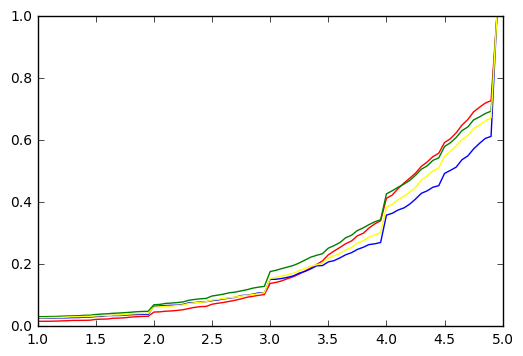

In [60]:
values, base = np.histogram(groupByProductWeight(swissDF), bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(groupByProductWeight(swissDF)), c='red')
values, base = np.histogram(groupByProductWeight(FrenchDF), bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(groupByProductWeight(FrenchDF)), c='blue')
values, base = np.histogram(groupByProductWeight(USDF), bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(groupByProductWeight(USDF)), c='green')
values, base = np.histogram(groupByProductWeight(GermanDF), bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(groupByProductWeight(GermanDF)), c='yellow')

In [61]:
stats.ks_2samp(groupByProductWeight(swissDF), groupByProductWeight(FrenchDF))

Ks_2sampResult(statistic=0.12259706487082556, pvalue=3.4070737723446524e-21)

In [62]:
stats.ks_2samp(groupByProductWeight(swissDF), groupByProductWeight(GermanDF))

Ks_2sampResult(statistic=0.057758994422904442, pvalue=4.9080268325017753e-09)

In [63]:
stats.ks_2samp(groupByProductWeight(swissDF), groupByProductWeight(USDF))

Ks_2sampResult(statistic=0.040893528922438943, pvalue=2.6582028571155286e-05)

In [64]:
scipy.stats.mannwhitneyu(groupByProductWeight(swissDF), groupByProductWeight(FrenchDF), alternative="greater")

MannwhitneyuResult(statistic=5001372.0, pvalue=0.99999999999998279)

In [65]:
scipy.stats.mannwhitneyu(groupByProductWeight(swissDF), groupByProductWeight(GermanDF), alternative="greater")

MannwhitneyuResult(statistic=17787279.0, pvalue=0.99999868210502485)

In [66]:
scipy.stats.mannwhitneyu(groupByProductWeight(swissDF), groupByProductWeight(USDF), alternative="greater")

MannwhitneyuResult(statistic=27085821.5, pvalue=0.46508971490465023)

In [67]:
scipy.stats.mannwhitneyu(groupByProductWeight(swissDF), groupByProductWeight(FrenchDF), alternative="less")

MannwhitneyuResult(statistic=5001372.0, pvalue=1.7174866416771352e-14)

In [68]:
scipy.stats.mannwhitneyu(groupByProductWeight(swissDF), groupByProductWeight(GermanDF), alternative="less")

MannwhitneyuResult(statistic=17787279.0, pvalue=1.3179279231116791e-06)

In [69]:
scipy.stats.mannwhitneyu(groupByProductWeight(swissDF), groupByProductWeight(USDF), alternative="less")

MannwhitneyuResult(statistic=27085821.5, pvalue=0.53491177489272923)

# Comparison of sentiment data

In [90]:
swissDF['sentiment'].describe()

count    289878.000000
mean          0.647099
std           0.499193
min          -0.998900
25%           0.608300
50%           0.879300
75%           0.951700
max           0.999900
Name: sentiment, dtype: float64

In [91]:
USDF['sentiment'].describe()

count    303939.000000
mean          0.591030
std           0.526901
min          -0.999200
25%           0.469900
50%           0.844200
75%           0.938900
max           0.999900
Name: sentiment, dtype: float64

In [92]:
FrenchDF['sentiment'].describe()

count    25642.000000
mean         0.618306
std          0.507349
min         -0.995200
25%          0.538075
50%          0.855500
75%          0.940100
max          0.999700
Name: sentiment, dtype: float64

In [93]:
GermanDF['sentiment'].describe()

count    153843.000000
mean          0.613706
std           0.511499
min          -0.998400
25%           0.518700
50%           0.855500
75%           0.944200
max           1.000000
Name: sentiment, dtype: float64

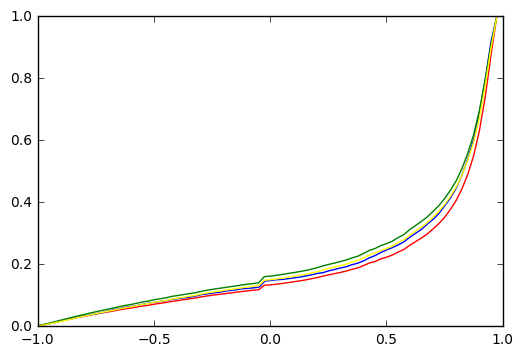

In [94]:
values, base = np.histogram(swissDF['sentiment'], bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(swissDF['sentiment']), c='red')
values, base = np.histogram(FrenchDF['sentiment'], bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(FrenchDF['sentiment']), c='blue')
values, base = np.histogram(USDF['sentiment'], bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(USDF['sentiment']), c='green')
values, base = np.histogram(GermanDF['sentiment'], bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(GermanDF['sentiment']), c='yellow')

In [98]:
scipy.stats.mannwhitneyu(swissDF['sentiment'], FrenchDF['sentiment'], alternative='greater')

MannwhitneyuResult(statistic=3978014063.5, pvalue=2.2754804180778284e-78)

In [97]:
scipy.stats.mannwhitneyu(swissDF['sentiment'],USDF[ 'sentiment'], alternative='greater')

MannwhitneyuResult(statistic=48044549864.5, pvalue=0.0)

In [95]:
scipy.stats.mannwhitneyu(swissDF['sentiment'],GermanDF[ 'sentiment'], alternative='greater')

MannwhitneyuResult(statistic=23594270745.5, pvalue=5.9458897003362479e-224)

In [101]:
scipy.stats.mannwhitneyu(swissDF['sentiment'], FrenchDF['sentiment'], alternative='less')

MannwhitneyuResult(statistic=3978014063.5, pvalue=1.0)

In [100]:
scipy.stats.mannwhitneyu(swissDF['sentiment'],USDF[ 'sentiment'], alternative='less')

MannwhitneyuResult(statistic=48044549864.5, pvalue=1.0)

In [99]:
scipy.stats.mannwhitneyu(swissDF['sentiment'],GermanDF[ 'sentiment'], alternative='less')

MannwhitneyuResult(statistic=23594270745.5, pvalue=1.0)

# Comparison of sentiment data with grouping 

In [106]:
def groupByProductSentiment (DF):
    productGroup = DF.groupby(['asin'])
    productFrame = pd.DataFrame(productGroup['sentiment'].agg(['count', 'mean']))
    overallGrouped = productFrame['mean']
    return overallGrouped

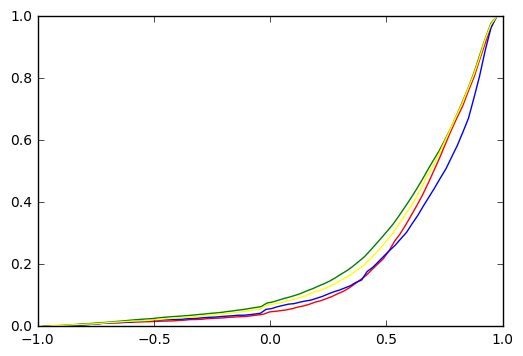

In [109]:
values, base = np.histogram(groupByProductSentiment(swissDF), bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(groupByProductSentiment(swissDF)), c='red')
values, base = np.histogram(groupByProductSentiment(FrenchDF), bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(groupByProductSentiment(FrenchDF)), c='blue')
values, base = np.histogram(groupByProductSentiment(USDF), bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(groupByProductSentiment(USDF)), c='green')
values, base = np.histogram(groupByProductSentiment(GermanDF), bins=80)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative/len(groupByProductSentiment(GermanDF)), c='yellow')


In [110]:
scipy.stats.mannwhitneyu(groupByProductSentiment(swissDF),groupByProductSentiment(FrenchDF),alternative='greater')

MannwhitneyuResult(statistic=5193347.0, pvalue=0.9999998400387009)

In [111]:
scipy.stats.mannwhitneyu(groupByProductSentiment(swissDF),groupByProductSentiment(GermanDF),alternative='greater')

MannwhitneyuResult(statistic=19491958.0, pvalue=3.8532493281254049e-05)

In [112]:
scipy.stats.mannwhitneyu(groupByProductSentiment(swissDF),groupByProductSentiment(USDF),alternative='greater')

MannwhitneyuResult(statistic=28896702.5, pvalue=5.7015873556121796e-12)

In [113]:
scipy.stats.mannwhitneyu(groupByProductSentiment(swissDF),groupByProductSentiment(FrenchDF),alternative='less')

MannwhitneyuResult(statistic=5193347.0, pvalue=1.5997169595193279e-07)

In [114]:
scipy.stats.mannwhitneyu(groupByProductSentiment(swissDF),groupByProductSentiment(GermanDF),alternative='less')

MannwhitneyuResult(statistic=19491958.0, pvalue=0.9999614683179896)

In [115]:
scipy.stats.mannwhitneyu(groupByProductSentiment(swissDF),groupByProductSentiment(USDF),alternative='less')

MannwhitneyuResult(statistic=28896702.5, pvalue=0.99999999999429856)

# Comparison of category ratings

As a reminder, here are the ratings divided by the most popular categories of swiss products, we'll now add the ratings of those same categories for products that come from other countries

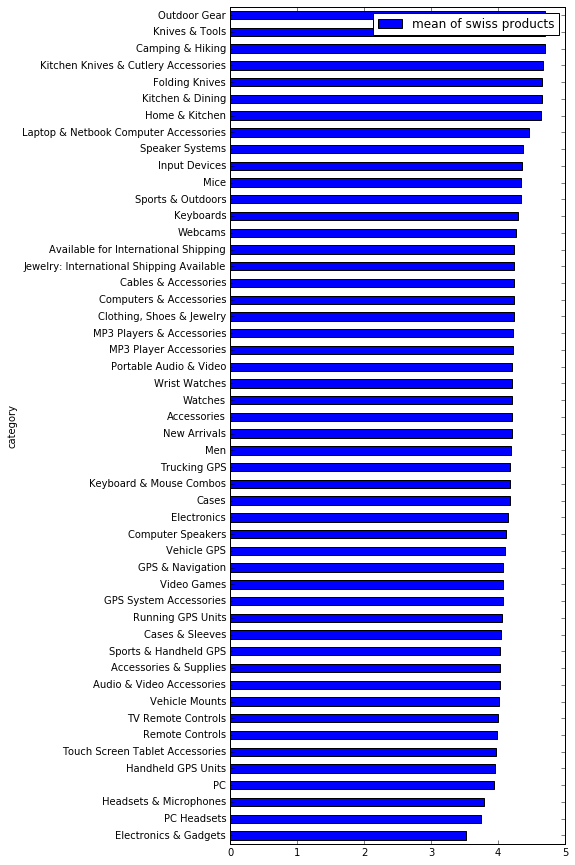

In [79]:
res.sort_values(by='mean of swiss products',ascending=True).plot.barh(figsize=(6,15))

In [62]:
RandomDF = transformCategories(RandomDF)
#GermanDF = transformCategories(GermanDF) getting rid of german and french products might be better, because there's not enough data on those products.
#FrenchDF = transformCategories(FrenchDF)
USDF = transformCategories(USDF)

NameError: name 'RandomDF' is not defined

In [81]:
flat = RandomDF.categories.apply(lambda x: ' '.join(x)).str
resRandom = categoriesCount.keys().to_series().map(lambda c: RandomDF[flat.contains(c)].overall.mean())

#flat = FrenchDF.categories.apply(lambda x: ' '.join(x)).str
#resFrench = categoriesCount.keys().to_series().map(lambda c: FrenchDF[flat.contains(c)].overall.mean())

#flat = GermanDF.categories.apply(lambda x: ' '.join(x)).str
#resGerman= categoriesCount.keys().to_series().map(lambda c: GermanDF[flat.contains(c)].overall.mean())

flat = USDF.categories.apply(lambda x: ' '.join(x)).str
resUS = categoriesCount.keys().to_series().map(lambda c: USDF[flat.contains(c)].overall.mean())

In [82]:
res['mean of random sample'] = resRandom
#res['mean of french products'] = resFrench # maybe remove the french, there are too few reviews so it's misleading
#res['mean of german products'] = resGerman
res['mean of US products'] = resUS

In [83]:
res.head()

,mean of swiss products,mean of random sample,mean of US products
category,,,
Electronics,4.151909,4.072893,4.089971
Computers & Accessories,4.237529,4.089750,4.242075
Cables & Accessories,4.240466,4.096739,4.280715
GPS & Navigation,4.077727,4.021834,4.041628
"Clothing, Shoes & Jewelry",4.236315,4.197909,4.246057


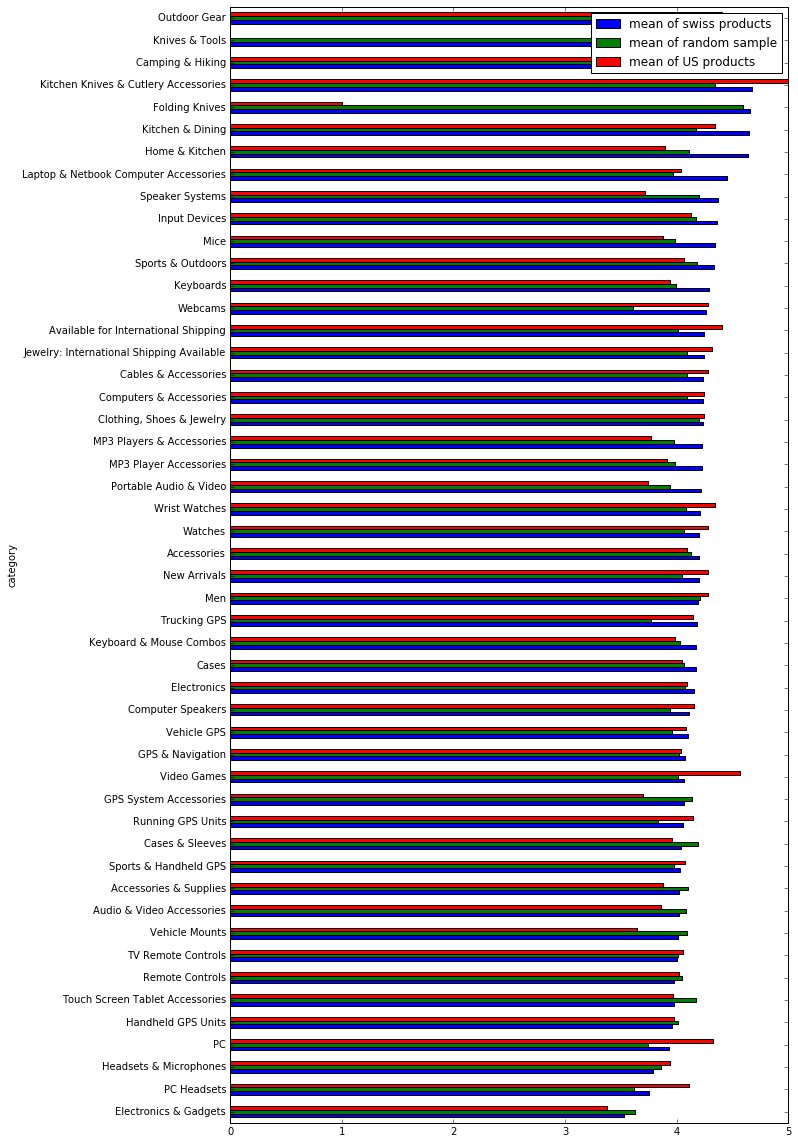

In [84]:
res.sort_values(by='mean of swiss products',ascending=True).plot.barh(figsize=(10,20))

# Mean of means

The graph above represents the mean of all product reviews. However this might lead to unexpected results because if a good product is reviewed many times and a bad one only a few, the mean could be high even though one out of 2 products is viable.

This isn't necessarily a problem, it depends on what we want to plot. So below we'll compute the mean of product means instead of the mean of all reviews.

In [85]:
productMean = swissDF
productMean['categories'] = productMean.categories.apply(lambda x : tuple(x))
productMean = productMean.groupby(['asin', 'categories'])['overall'].mean()
productMean = productMean.to_frame().reset_index()

In [86]:
flat = productMean.categories.apply(lambda x: ' '.join(x)).str
res = categoriesCount.keys().to_series().map(lambda c: productMean[flat.contains(c)].overall.mean())

In [87]:
res = res.reset_index(drop=False)
res.columns = ['category', 'mean of means']
res = res.set_index(['category'])

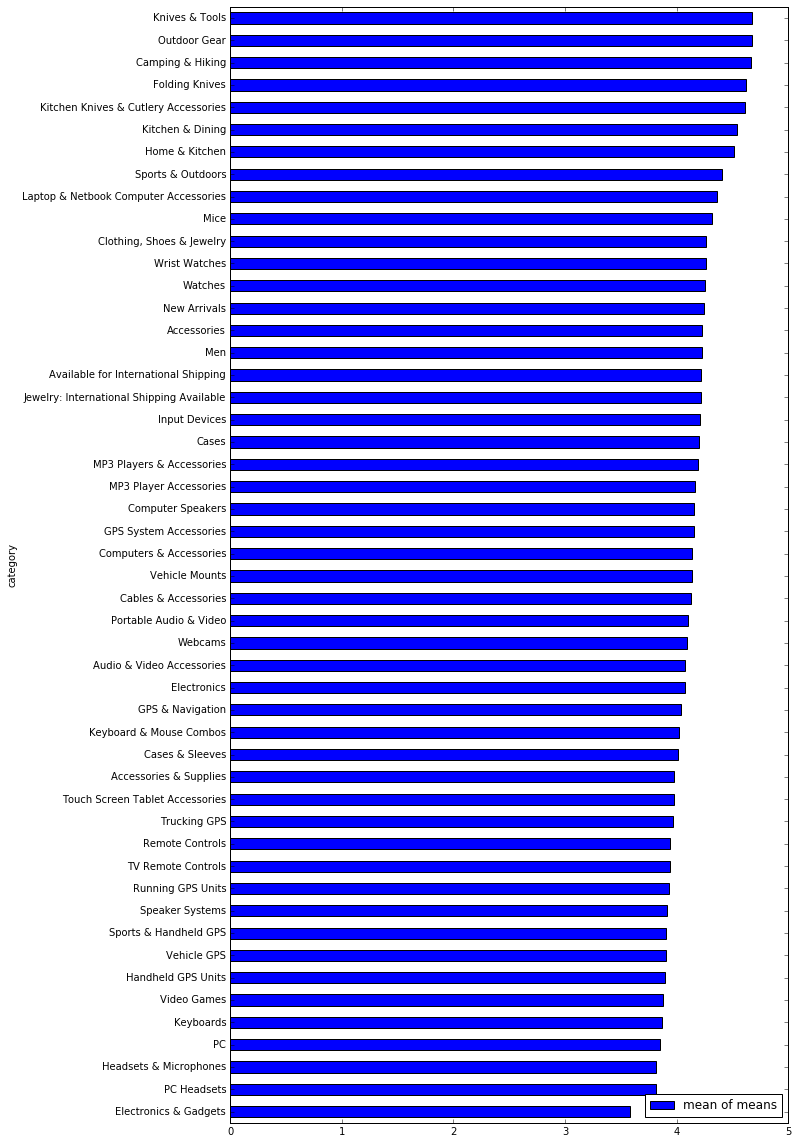

In [88]:
res.sort_values(by='mean of means',ascending=True).plot.barh(figsize=(10,20))

We'll now plot the mean of all reviews on the same graph for easier comparison

In [89]:
flat = swissDF.categories.apply(lambda x: ' '.join(x)).str
resSwiss= categoriesCount.keys().to_series().map(lambda c: swissDF[flat.contains(c)].overall.mean())
res['mean of individual reviews'] = resSwiss

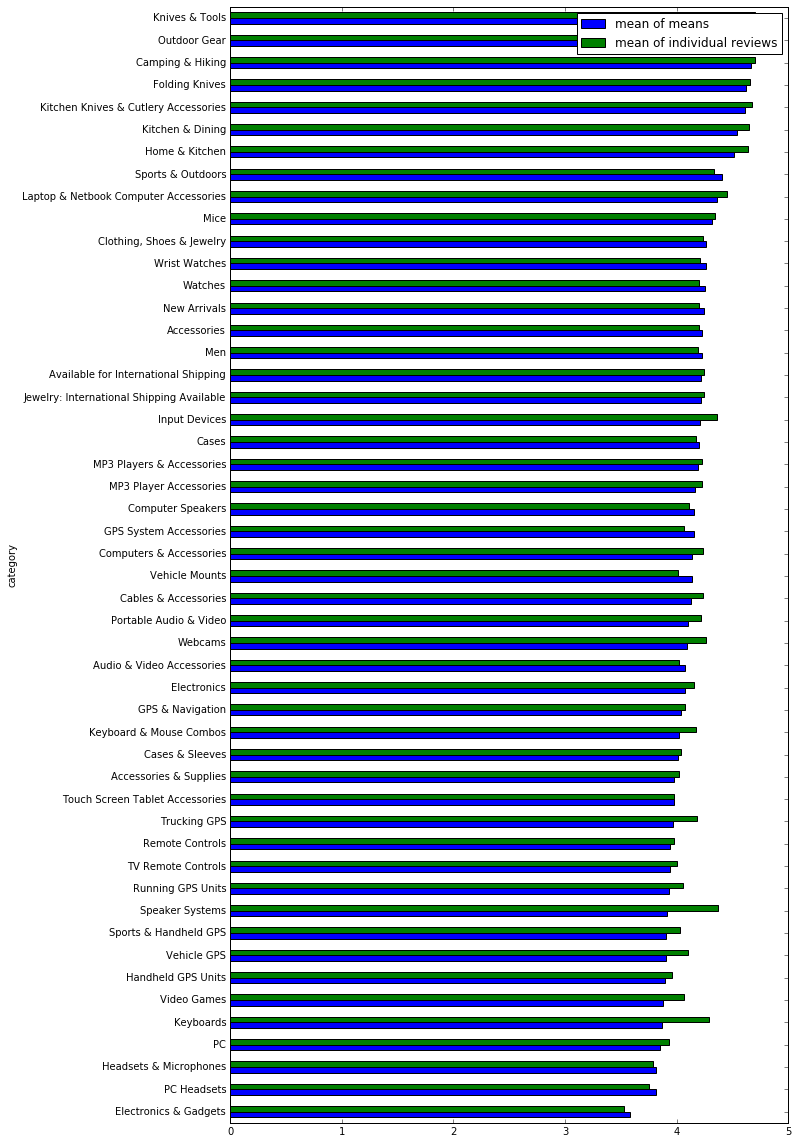

In [90]:
res.sort_values(by='mean of means',ascending=True).plot.barh(figsize=(10,20))

As we can observe above, some ratings vary by a significant margin, but most of the time the difference is pretty msall